In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
import math
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [218]:
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE','defaultpaymentnextmonth'] + ['PAY_'+str(x) for x in [0, 2, 3, 4, 5, 6]]
int_vars = ['AGE']
float_vars = ['LIMIT_BAL'] + ['BILL_AMT'+str(x) for x in range(1, 7)] + ['PAY_AMT'+str(x) for x in range(1, 7)]
dtypes = {col : 'category' for col in cat_vars}
for col in int_vars:
    dtypes[col] = 'int32'
for col in float_vars:
    dtypes[col] = 'float32'

In [219]:
data=pd.read_csv(r'C:\Users\Lenovo\Desktop\PROYECTOS_PYTHON\Modelamiento\data\default_creditcardclients.csv',sep=';',dtype=dtypes)
data.head(3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaultpaymentnextmonth
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LIMIT_BAL                30000 non-null  float32 
 1   SEX                      30000 non-null  category
 2   EDUCATION                30000 non-null  category
 3   MARRIAGE                 30000 non-null  category
 4   AGE                      30000 non-null  int32   
 5   PAY_0                    30000 non-null  category
 6   PAY_2                    30000 non-null  category
 7   PAY_3                    30000 non-null  category
 8   PAY_4                    30000 non-null  category
 9   PAY_5                    30000 non-null  category
 10  PAY_6                    30000 non-null  category
 11  BILL_AMT1                30000 non-null  float32 
 12  BILL_AMT2                30000 non-null  float32 
 13  BILL_AMT3                30000 non-null  float32 
 14  BILL_A

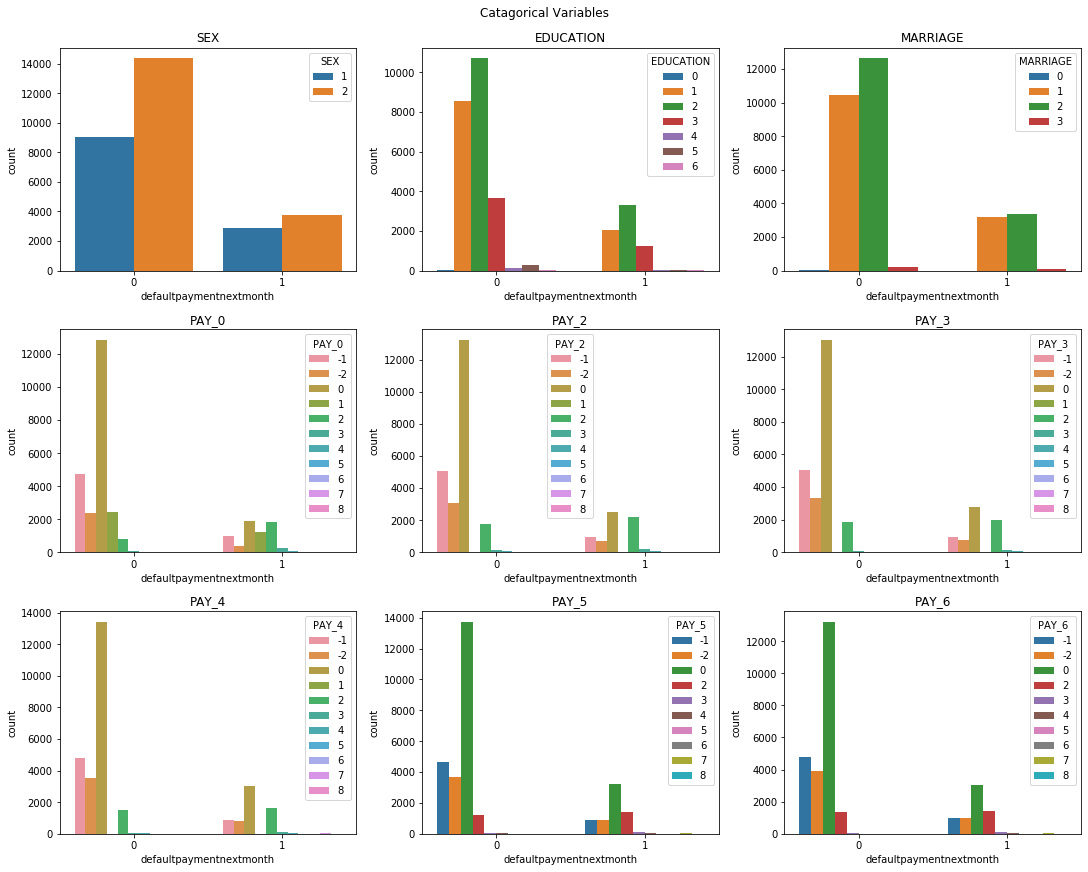

In [221]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


cat_vars = [var for var in cat_vars if var !=  'defaultpaymentnextmonth']
ncols = 3
nrows = int(math.ceil(len(cat_vars)/ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), constrained_layout=True)
axs = trim_axs(axs, len(cat_vars))
f.suptitle('Catagorical Variables')
for ax, var in zip(axs, cat_vars):
    sns.countplot(data['defaultpaymentnextmonth'], hue=data[var], ax=ax)
    ax.set_title(var)

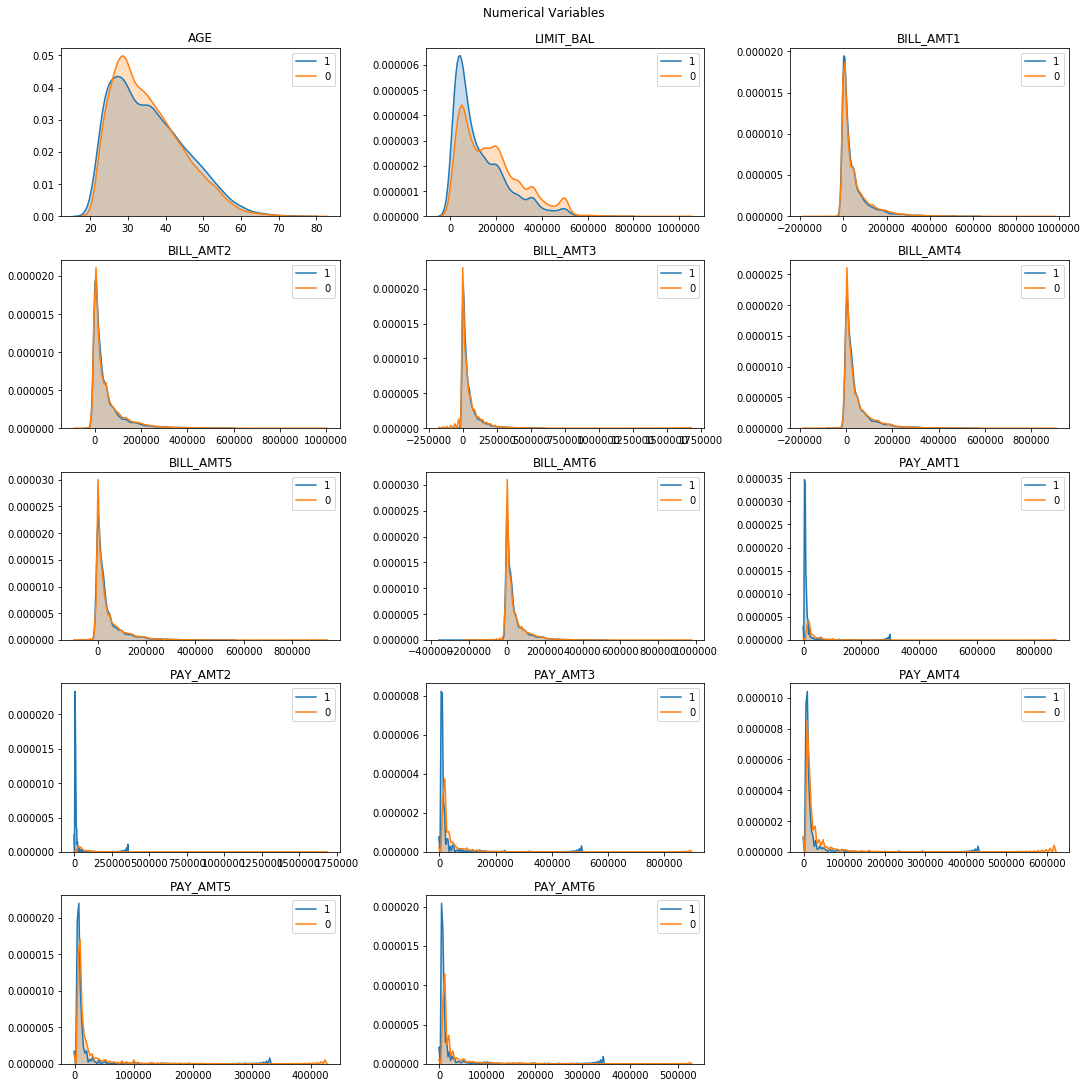

In [222]:
num_vars = int_vars + float_vars

ncols = 3
nrows = int(math.ceil(len(num_vars)/ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), constrained_layout=True)
axs = trim_axs(axs, len(num_vars))
f.suptitle('Numerical Variables')
for ax, var in zip(axs, num_vars):
    for val in data['defaultpaymentnextmonth'].unique():
        sns.kdeplot(data.loc[data['defaultpaymentnextmonth'] == val, var], shade=True, ax=ax, label=val);
    ax.set_title(var)

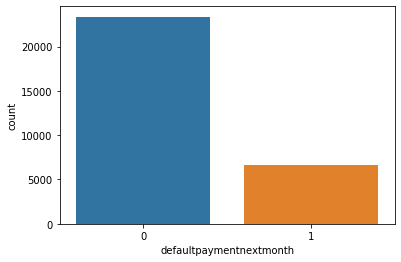

In [223]:

# Distribution of the Target variable.
sns.countplot(data['defaultpaymentnextmonth']);

In [224]:
for col in ['PAY_'+str(x) for x in [0, 2, 3, 4, 5, 6]]:
    data[col] = (data[col].astype('int') + 3).astype('category')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaultpaymentnextmonth
0,20000.0,2,2,1,24,5,5,2,2,1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,2,5,3,3,3,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,3,3,3,3,3,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,3,3,3,3,3,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,2,3,2,3,3,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [225]:
dataxgb=data
dataxgb.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaultpaymentnextmonth
0,20000.0,2,2,1,24,5,5,2,2,1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,2,5,3,3,3,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


In [226]:
y = dataxgb['defaultpaymentnextmonth']
dataxgb.drop(columns = ['defaultpaymentnextmonth'], inplace=True)
y.value_counts()

0    23364
1     6636
Name: defaultpaymentnextmonth, dtype: int64

In [227]:
dataxgb= dataxgb[num_vars]
dataxgb.head(2)

,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,24,20000.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,26,120000.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0


In [228]:
dataxgb.head(2)

,AGE,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,24,20000.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,26,120000.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0


In [229]:
X_train, X_test, y_train, y_test = train_test_split(dataxgb, y, test_size=0.25, random_state=42, stratify = y)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')
del data, y

X_train: (22500, 14), y_train: (22500,), X_test: (7500, 14), y_test: (7500,)


In [230]:
X_test_disp = X_test.copy()

In [231]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

In [232]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dataxgb)

In [233]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], dataxgb.iloc[0, :])

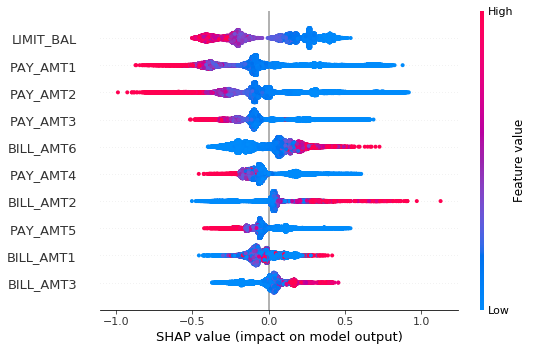

In [234]:
shap.summary_plot(shap_values, features=dataxgb, class_inds=[0], max_display=10)

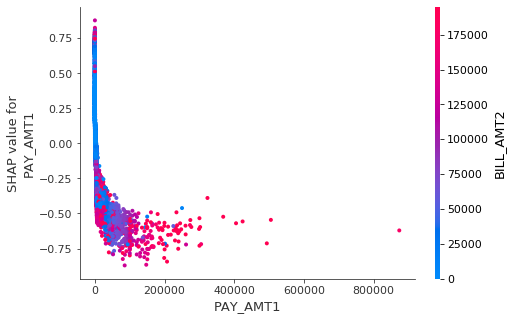

In [240]:
shap.dependence_plot('PAY_AMT1', shap_values, dataxgb)